In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

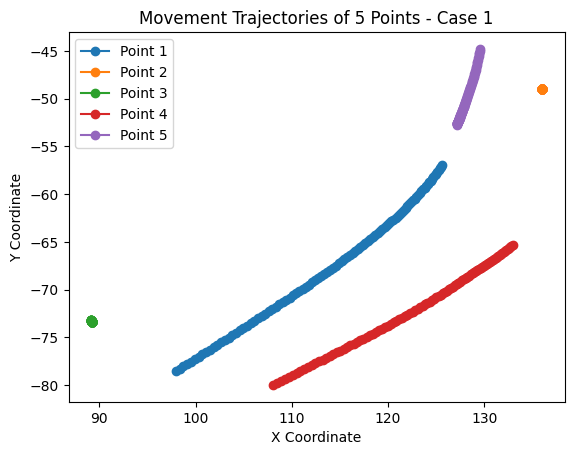

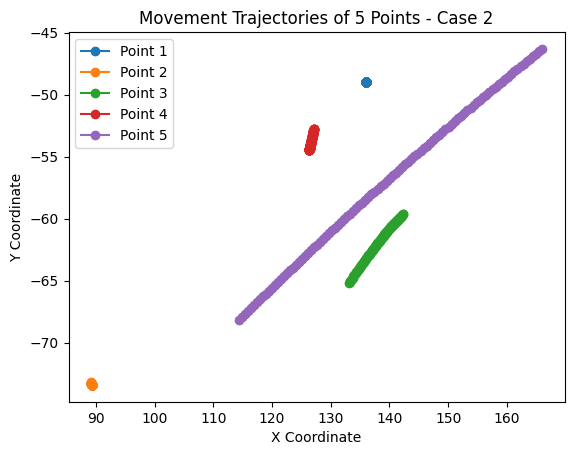

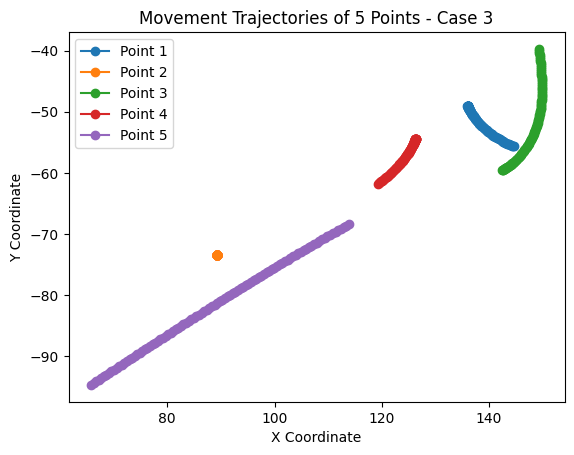

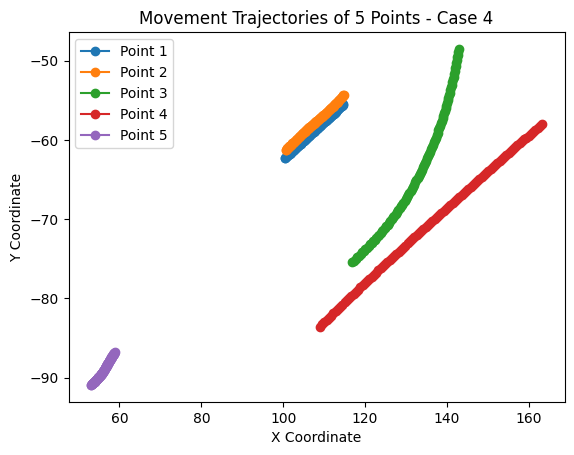

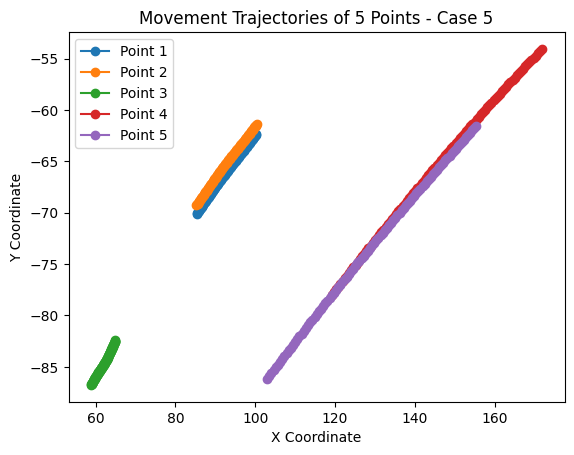

In [2]:
df = pd.read_csv('/DATA1/rzhou/ika/multi_testcases/inD_multi_full.csv')


# 确定总行数
total_rows = 500

# 每个case包含的行数
rows_per_case = 100

# 计算需要多少个case
num_cases = total_rows // rows_per_case

# 为每个case绘制轨迹
for case in range(num_cases):
    # 创建一个图和坐标轴
    fig, ax = plt.subplots()
    
    # 获取当前case的数据段
    case_df = df.iloc[case*rows_per_case : (case+1)*rows_per_case]
    
    # 为每个点绘制轨迹
    for i in range(1, 6):
        x_coords = case_df[f'x{i}']
        y_coords = case_df[f'y{i}']
        ax.plot(x_coords, y_coords, marker='o', label=f'Point {i}')

    # 添加图例
    ax.legend()

    # 添加标题和坐标轴标签
    ax.set_title(f'Movement Trajectories of 5 Points - Case {case+1}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # 显示图形
    plt.show()

/tmp/ipykernel_3632960/2236412719.py:42: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(x, y)


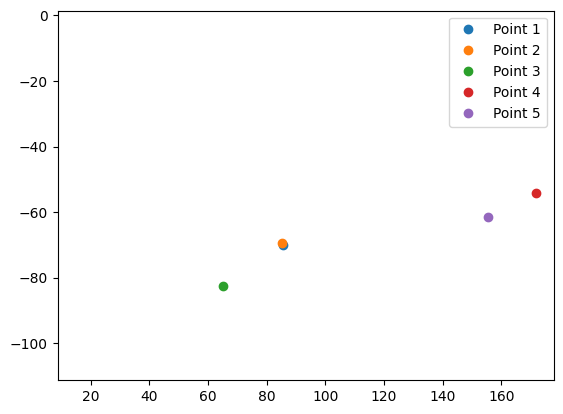

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 加载DataFrame
df = pd.read_csv('/DATA1/rzhou/ika/multi_testcases/inD_multi_full.csv')

# 设置参数
rows_per_case = 100
total_cases = 500 // rows_per_case

# 创建图形和轴
fig, ax = plt.subplots()

# 初始化绘制点的占位符
points = [ax.plot([], [], 'o', label=f'Point {i}')[0] for i in range(1, 6)]
# 设置轴界限
ax.set_xlim(df[['x1', 'x2', 'x3', 'x4', 'x5']].min().min(), df[['x1', 'x2', 'x3', 'x4', 'x5']].max().max())
ax.set_ylim(df[['y1', 'y2', 'y3', 'y4', 'y5']].min().min(), df[['y1', 'y2', 'y3', 'y4', 'y5']].max().max())
ax.legend()

# 初始化函数，设置动画开始时的背景
def init():
    for point in points:
        point.set_data([], [])
    return points

# 更新函数，用于动画的每一帧
def update(frame):
    case_number = frame // rows_per_case
    row_within_case = frame % rows_per_case
    
    start_row = int(case_number * rows_per_case)
    end_row = int(start_row + row_within_case + 1)
    case_df = df.iloc[start_row:end_row]
    
    # 只显示每个点的当前位置
    for i, point in enumerate(points, start=1):
        x = case_df.iloc[-1][f'x{i}']
        y = case_df.iloc[-1][f'y{i}']
        point.set_data(x, y)
    return points

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=total_cases*rows_per_case, init_func=init, blit=True, repeat=False)
ani.save('all_cases_animation.mp4', fps=25, extra_args=['-vcodec', 'libx264']) 
plt.show()  # 展示动画


In [1]:
import pickle

# 假设你有一个pickle文件名为example.pkl
filename = '/home/rzhou/Projects/timegan-pytorch/output/inD_multi-epoch2000_standardscaling/fake_data.pickle'

# 以二进制读取模式打开文件
with open(filename, 'rb') as file:
    # 使用pickle.load()方法加载并反序列化对象
    generated_data = pickle.load(file)

# 现在你可以使用data对象了
#print(data)
print(generated_data.shape)
print(generated_data)

(1648, 100, 10)
[[[-0.47889093  0.3636132   0.22946377 ...  0.42170456  0.13341811
   -0.25119314]
  [-1.3764559   0.5751275   1.7278409  ... -0.5608212   0.7209494
    1.0615838 ]
  [-1.1620091   0.7258049   1.2778025  ...  0.18006448  1.5989504
    0.37881306]
  ...
  [-1.9607434   0.23769441  1.1406897  ... -0.84325254  0.8326938
   -0.672259  ]
  [-2.0491123   0.1527065   1.7820945  ... -1.1728063  -0.01704732
   -1.0364337 ]
  [-1.9633199   0.28330353  2.1239157  ... -1.2762489  -0.70565027
   -1.0545446 ]]

 [[-1.0930859  -0.8014249  -0.5876895  ...  0.47445947 -1.8780414
    1.410041  ]
  [-0.01711017 -1.0017387  -1.2877022  ...  0.3845914  -1.0930672
    0.8481449 ]
  [-0.08687776 -1.0360289  -1.5167546  ...  0.46013522 -1.9730476
    1.2796609 ]
  ...
  [ 0.6846615  -0.72627366  0.087018   ... -0.37495896  0.53926563
    0.5367367 ]
  [ 0.63098955 -0.7613634   0.13400291 ... -0.34215873  0.4511349
    0.34888646]
  [ 0.55503464 -0.8129285   0.18165152 ... -0.20203881  0.272822

In [2]:
import os
from typing import Union, Tuple, List
import warnings
warnings.filterwarnings("ignore")

# 3rd party modules
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def data_preprocess(
    file_name: str, 
    max_seq_len: int, 
    padding_value: float=-10.0,
    impute_method: str="mode", 
    scaling_method: str="minmax", 
) -> Tuple[np.ndarray, np.ndarray, List]:
    """Load the data and preprocess into 3d numpy array.
    Preprocessing includes:
    1. Remove outliers
    2. Extract sequence length for each patient id
    3. Impute missing data 
    4. Normalize data
    6. Sort dataset according to sequence length

    Args:
    - file_name (str): CSV file name
    - max_seq_len (int): maximum sequence length
    - impute_method (str): The imputation method ("median" or "mode") 
    - scaling_method (str): The scaler method ("standard" or "minmax")

    Returns:
    - processed_data: preprocessed data
    - time: ndarray of ints indicating the length for each data
    - params: the parameters to rescale the data 
    """

    #########################
    # Load data
    #########################

    index = 'caseID'
    #index='trackID'

    # Load csv
    print("Loading data...\n")
    ori_data = pd.read_csv(file_name)

    # Remove spurious column, so that column 0 is now 'admissionid'.
    if ori_data.columns[0] == "Unnamed: 0":  
        ori_data = ori_data.drop(["Unnamed: 0"], axis=1)

    #########################
    # Remove outliers from dataset
    #########################
    no = ori_data.shape[0]
    z_scores = stats.zscore(ori_data, axis=0, nan_policy='omit')
    #Z-score是怎么算的，滤去的都是什么样的数据，我的testcases也需要滤去吗？
    z_filter = np.nanmax(np.abs(z_scores), axis=1) < 3
    #保留那些在每个特征上的Z-score绝对值都小于3的样本。
    #ori_data = ori_data[z_filter]
    #print(f"Dropped {no - ori_data.shape[0]} rows (outliers)\n")

    # Parameters
    uniq_id = np.unique(ori_data[index])
    no = len(uniq_id)
    dim = len(ori_data.columns) - 1

    #########################
    # Impute, scale and pad data
    #########################
    
    # Initialize scaler
    if scaling_method == "minmax":
        scaler = MinMaxScaler()
        scaler.fit(ori_data)
        params = [scaler.data_min_, scaler.data_max_]
    
    elif scaling_method == "standard":
        scaler = StandardScaler()
        scaler.fit(ori_data)
        params = [scaler.mean_, scaler.var_]

    # Imputation values
    if impute_method == "median":
        impute_vals = ori_data.median()
    elif impute_method == "mode":
        impute_vals = stats.mode(ori_data).mode[0]
    else:
        raise ValueError("Imputation method should be `median` or `mode`")    

    # TODO: Sanity check for padding value
    # if np.any(ori_data == padding_value):
    #     print(f"Padding value `{padding_value}` found in data")
    #     padding_value = np.nanmin(ori_data.to_numpy()) - 1
    #     print(f"Changed padding value to: {padding_value}\n")
    # padding填充值是用于使序列具有相同长度的特殊值，以便在神经网络中进行处理，没有实际数值
    
    # Output initialization
    output = np.empty([no, max_seq_len, dim])  # Shape:[no, max_seq_len, dim]
    # preprocessed data
    output.fill(padding_value)
    time = []

    # For each uniq id
    for i in tqdm(range(no)):
        # Extract the time-series data with a certain admissionid

        curr_data = ori_data[ori_data[index] == uniq_id[i]].to_numpy()

        # Impute missing data
        curr_data = imputer(curr_data, impute_vals)

        # Normalize data
        curr_data = scaler.transform(curr_data)
        
        # Extract time and assign to the preprocessed data (Excluding ID)
        curr_no = len(curr_data)

        # Pad data to `max_seq_len`
        if curr_no >= max_seq_len:
            output[i, :, :] = curr_data[:max_seq_len, 1:]  # Shape: [1, max_seq_len, dim]
            time.append(max_seq_len)
        else:
            output[i, :curr_no, :] = curr_data[:, 1:]  # Shape: [1, max_seq_len, dim]
            time.append(curr_no)
        #修剪或填充至max_seq_len

    return output, time, params, max_seq_len, padding_value


#这个其实我的testcases应该用不到，因为我没有missing value吧
def imputer(
    curr_data: np.ndarray, 
    impute_vals: List, 
    zero_fill: bool = True
) -> np.ndarray:
    """Impute missing data given values for each columns.

    Args:
        curr_data (np.ndarray): Data before imputation.
        impute_vals (list): Values to be filled for each column.
        zero_fill (bool, optional): Whather to Fill with zeros the cases where 
            impute_val is nan. Defaults to True.

    Returns:
        np.ndarray: Imputed data.
    """

    curr_data = pd.DataFrame(data=curr_data)
    impute_vals = pd.Series(impute_vals)
    
    # Impute data
    imputed_data = curr_data.fillna(impute_vals)

    # Zero-fill, in case the `impute_vals` for a particular feature is `nan`.
    imputed_data = imputed_data.fillna(0.0)

    # Check for any N/A values
    if imputed_data.isnull().any().any():
        raise ValueError("NaN values remain after imputation")

    return imputed_data.to_numpy()


In [4]:
data_path = "/DATA1/rzhou/ika/multi_testcases/inD_multi_full.csv"
max_seq_len = 100
X, T, params_rescale, max_seq_len, padding_value = data_preprocess(
    data_path, max_seq_len
)
print(params_rescale)

Loading data...



100%|██████████| 3546/3546 [00:03<00:00, 1028.21it/s]

[array([   1.     ,   11.43217, -106.24213,   10.75786, -111.26369,
         12.24794, -110.17841,    9.32805, -108.40186,    8.70607,
       -109.85039]), array([ 3.5460000e+03,  1.7292969e+02,  3.1141000e-01,  1.7443509e+02,
       -1.6314100e+00,  1.7076889e+02, -2.6096500e+00,  1.7200540e+02,
       -2.1739100e+00,  1.7783504e+02,  1.4262500e+00])]


In [5]:
cut_params_rescale=[arr[1:] for arr in params_rescale]
print(cut_params_rescale)

[array([  11.43217, -106.24213,   10.75786, -111.26369,   12.24794,
       -110.17841,    9.32805, -108.40186,    8.70607, -109.85039]), array([172.92969,   0.31141, 174.43509,  -1.63141, 170.76889,  -2.60965,
       172.0054 ,  -2.17391, 177.83504,   1.42625])]


In [27]:

data_min_ = cut_params_rescale[0]  # 这里是最小值数组
data_max_ = cut_params_rescale[1]  # 这里是最大值数组大值数组
rescaled_generated_data = np.empty_like(generated_data)
for feature_idx in range(generated_data.shape[-1]):
    # 对每个特征单独处理
    min_val = data_min_[feature_idx]
    max_val = data_max_[feature_idx]
    # MinMaxScaler 的逆变换公式
    rescaled_generated_data[..., feature_idx] = generated_data[..., feature_idx] * (max_val - min_val) + min_val
print(rescaled_generated_data)

[[[ 41.585148  -45.708145   83.812584  ... -21.2854     40.895535
   -47.672253 ]
  [ 45.018715  -51.956314   86.22879   ... -19.959496   52.57768
   -48.523148 ]
  [ 41.834057  -58.59987    79.71879   ... -14.329117   51.321358
   -43.227676 ]
  ...
  [ 45.81991   -31.663963  101.30077   ... -16.28254    17.163864
   -20.461426 ]
  [ 52.985394  -24.499207  101.36373   ... -16.287697   28.915146
   -51.640213 ]
  [ 45.886066  -32.178482  101.912796  ... -15.769775   18.35046
   -20.280563 ]]

 [[ 36.4105    -31.993408   72.846985  ... -27.950165   35.221725
   -34.349907 ]
  [ 41.766346  -25.747787   75.202225  ... -31.143486   40.311523
   -30.384186 ]
  [ 42.8698    -28.356842   75.26642   ... -29.32315    42.53568
   -25.365028 ]
  ...
  [  9.378795  -24.469467   96.86992   ... -31.894691   27.71127
   -19.719917 ]
  [  9.21231   -23.251167   75.03487   ... -33.2212     30.125135
   -24.809853 ]
  [  9.583954  -24.694817   96.89904   ... -32.114967   27.97886
   -19.799614 ]]

 [[ 4

In [28]:
print(rescaled_generated_data.shape)

(1773, 100, 10)


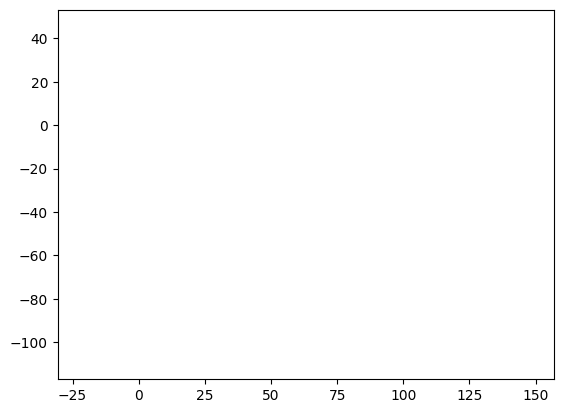

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 假定rescaled_generated_data为(1773, 100, 10)的NumPy数组
# 请确保已经正确加载了rescaled_generated_data

frames_per_second = 5  # 定义每秒展示的帧数
total_seconds_per_case = 20  # 定义每个案例表示的总秒数
frames_per_case = frames_per_second * total_seconds_per_case  # 计算每个案例的总帧数

# 创建图形和轴
fig, ax = plt.subplots()

# 根据数据设置轴界限
# 注意：这里假设x和y坐标分别位于最后一维的偶数和奇数索引位置
x_min, x_max = np.min(rescaled_generated_data[..., ::2]), np.max(rescaled_generated_data[..., ::2])
y_min, y_max = np.min(rescaled_generated_data[..., 1::2]), np.max(rescaled_generated_data[..., 1::2])
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# 初始化绘制点的占位符，此处对应5个点
points = [ax.plot([], [], 'o', label=f'Point {i+1}')[0] for i in range(5)]

# 初始化函数，设置动画开始时的背景
def init():
    for point in points:
        point.set_data([], [])
    return points

# 更新函数，用于动画的每一帧
def update(frame):
    # 根据总帧数来计算当前应该展示的数据索引
    current_index = frame % 100  # 每100帧数据对应一个完整周期

    # 根据帧数选择对应的数据
    for i, point in enumerate(points):
        # 选择对应案例的数据
        case_data = rescaled_generated_data[5 + i]  # 选择最后五行作为案例
        x = case_data[current_index, i*2]  # x坐标
        y = case_data[current_index, i*2+1]  # y坐标
        point.set_data(x, y)
    return points

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=total_seconds_per_case * frames_per_second,
                              init_func=init, blit=True, repeat=True)

plt.show()

# 注意：由于当前环境限制，实际保存动画需在你的本地环境执行
ani.save('trajectory_animation.mp4', fps=frames_per_second, extra_args=['-vcodec', 'libx264'])
